# Restricted Boltzmann Machine - MNIST

## Imports

In [1]:
import sys, datetime
import os

# numpy
import numpy as np
from numpy import exp,sqrt,log,log10,sign,power,cosh,sinh,tanh,floor
rng = np.random.default_rng(12345)
np.set_printoptions(precision=4)

# matplotlib
import matplotlib as mpl
%matplotlib inline
from matplotlib.ticker import NullFormatter, MaxNLocator
mpl.rcParams.update({"font.size": 12})  #"text.usetex": True,})
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

# to load MNIST
from sklearn.datasets import fetch_openml

!mkdir FIG 
!mkdir FIG/FRAME
!mkdir WEIGHTS 
!mkdir DATA
!mkdir img

mkdir: cannot create directory ‘FIG’: File exists
mkdir: cannot create directory ‘FIG/FRAME’: File exists
mkdir: cannot create directory ‘WEIGHTS’: File exists
mkdir: cannot create directory ‘DATA’: File exists
mkdir: cannot create directory ‘img’: File exists


## Load data

In [2]:
X_original, Y_original = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)
#print(X_original.shape)

## Parameters

In [3]:
################################
#    CHOICE OF PARAMETERS      #
################################
# number of MNIST digits to keep (e.g., Ndigit=3 keeps 0,1,2)
Ndigit=3
# number of hidden units
L = 3 ###########SEE Pdf
# use (+1,-1) if SPINS, otherwise use bits (1,0), ising spins
SPINS=False  
# use one-hot encoding in hidden space if POTTS (use only if SPINS=False)
POTTS=False


dname='DATA/'
################################

# x_min =0 if bits, x_min=-1 if SPINS
# level_gap is the difference in values between the max (1) and the min (x_min)
if SPINS:
    x_min=-1
    level_gap=2.
else:
    x_min=0
    level_gap=1.

if POTTS:
    str_simul="RBM_Potts"
    # in one-hot encoding, number of possible hidden states matches L
    Nz=L
else:
    str_simul="RBM"
    # number of possible hidden states: 2**L
    Nz=2**L
    
if POTTS and SPINS: 
    print("\n\n>>>>>>>> WARNING:  POTTS and SPINS cannot coexist\n\n")

## Select data, and digitalize them two levels

('7', '8', '9')
dataset with 21076 points, each with 784 bits

first 10 MNIST data points


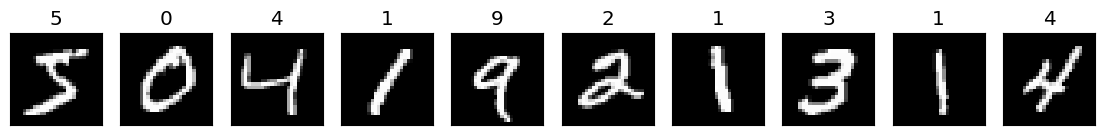

first 10 MNIST-3 data points


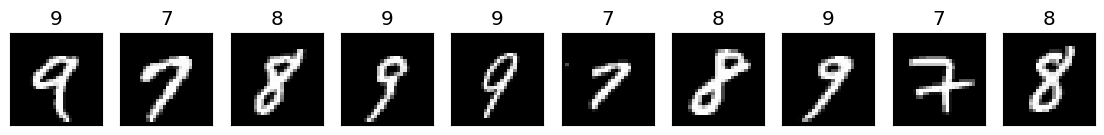

first 10 MNIST-3 data points, binarized


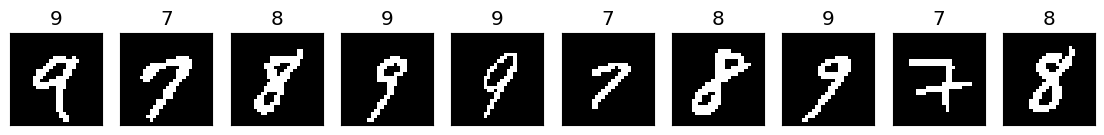

each of Nd=21076 data has D=784 bits


In [4]:
def show_MNIST(x, y=[], z=[], Nex=5, S=1.4, side=0, colors=[]):
    """Show digits"""
    if side==0: side = int(sqrt(x.shape[1]))
    if len(y)<1: y=np.full(Nex,"")
    colors=np.array(colors)
    fig, AX = plt.subplots(1,Nex,figsize=(S*Nex,S))
    
    for i, img in enumerate(x[:Nex].reshape(Nex, side, side)):
        if len(colors)==0: newcmp = "grey"
        else:
            col= colors[0] + (colors[1]-colors[0])*(i+1)/(Nex+1)
            newcmp = ListedColormap((col,(1,1,1,1)))
        ax=AX[i]
        ax.imshow(img, cmap=newcmp)
        ax.set_xticks([])
        ax.set_yticks([])
        if len(y)>0: ax.set_title(y[i])
        if len(z)>0: ax.set_title(''.join(map(str, z[i])),fontsize=9)
    plt.show()

def MNIST_bit(X,side=28,level=0.5):
    NX=len(X)
    #print(X.shape)
    print(f"dataset with {NX} points, each with {len(X[0])} bits\n")
    if side==14:
        X = np.reshape(X,(NX,28,28))
        # new value = average over 4 values in a 2x2 square
        Xr = 0.25*(X[:,0::2,0::2]+X[:,1::2,0::2]+X[:,0::2,1::2]+X[:,1::2,1::2])
        X  = Xr.reshape(NX,side**2)
    #print(X.shape)
    # binarize data and then convert it to 1/0 or 1/-1
    X = np.where(X/255 > level, 1, x_min)
    return X.astype("int")

list_10_digits = ('0','1','2','3','4','5','6','7','8','9')
list_digits = list_10_digits[-Ndigit:] ########to fine grain set digits  CHOSEN  7-8-9
print(list_digits)
keep=np.isin(Y_original, list_digits)
X_keep,Y=X_original[keep],Y_original[keep]

data,label = MNIST_bit(X_keep),Y
data,label = data.astype("int"),label.astype("int")
print("first 10 MNIST data points")
show_MNIST(X_original, Y_original,Nex=10)
print(f"first 10 MNIST-{Ndigit} data points")
show_MNIST(X_keep, label,Nex=10)
print(f"first 10 MNIST-{Ndigit} data points, binarized")
show_MNIST(data, label,Nex=10)

# number of data points
Nd = len(data)
# number of visible units
D  = len(data[1])

print(f'each of Nd={Nd} data has D={D} bits')

## Plotting data stats

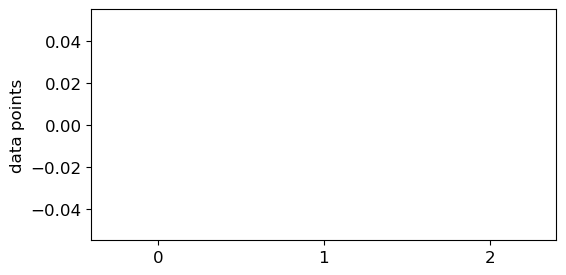

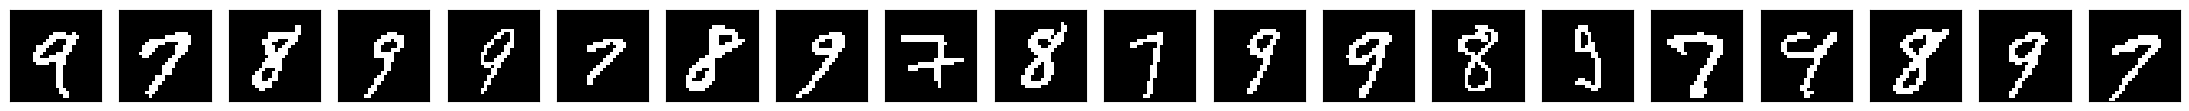

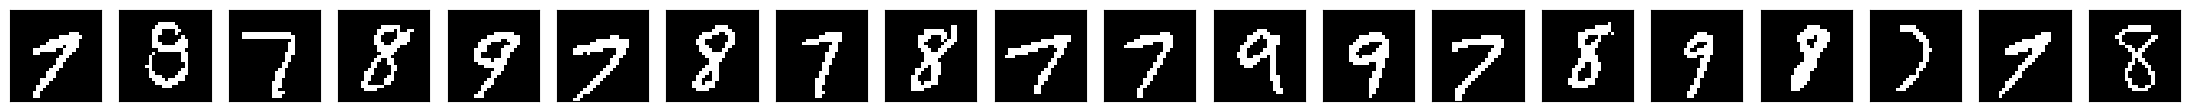

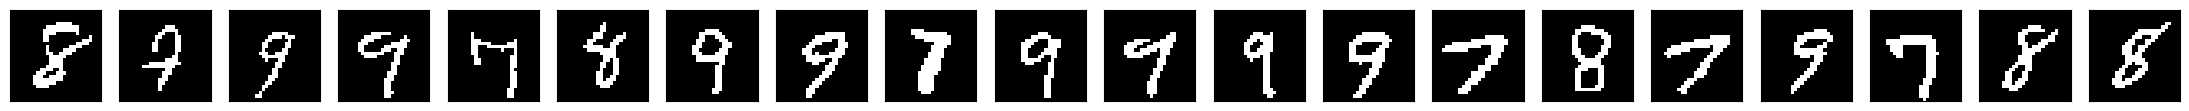

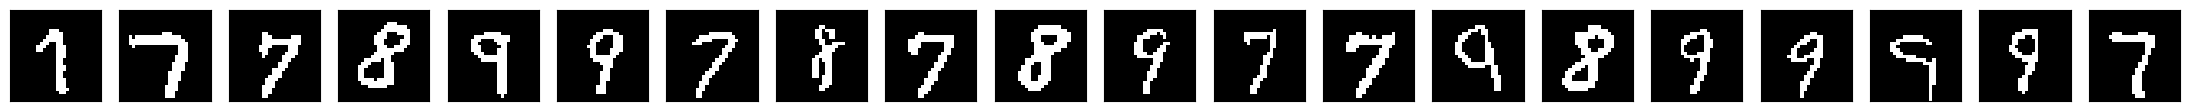

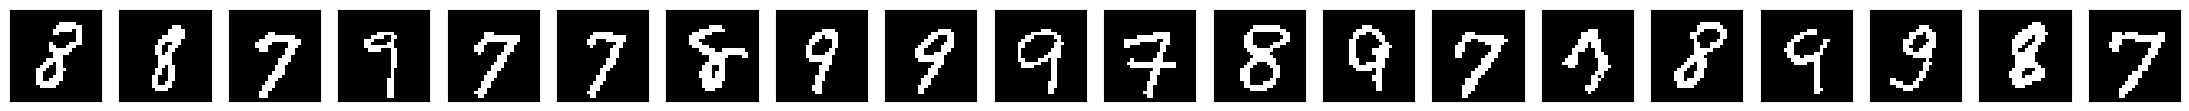

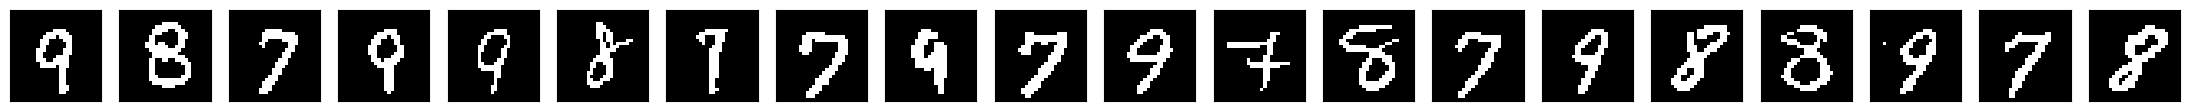

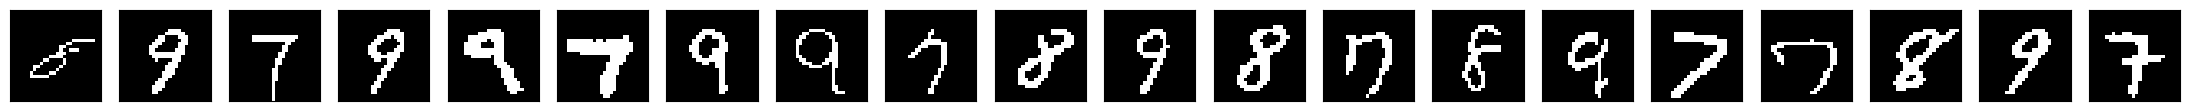

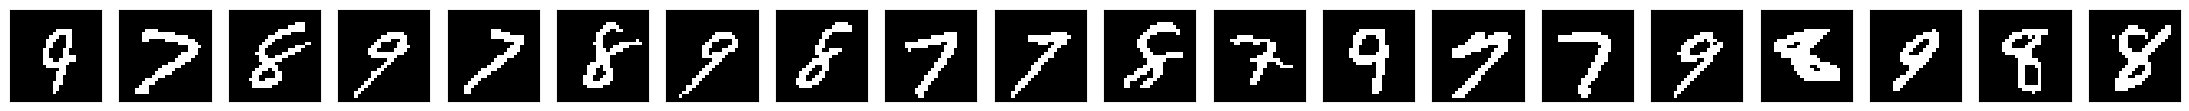

In [5]:
fig, ax = plt.subplots(1,1,figsize=(6,3))
ax.hist(np.sort(label),bins=np.arange(Ndigit+1)-1/2,density=False,rwidth=0.55,color="g")#np.sort(label)
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
ax.set_ylabel("data points")
plt.show()
for i in range(8): show_MNIST(data[i*20:],Nex=20)

## Contrastive divergence (CD)


In [6]:
# eq(213) page 97, activation via sigmoid
# taking into account energy gap 2 for "spin" variables (-1,1)
#@jit(parallel=True)
def CD_step(v_in,wei,bias,details=False,POTTS=False):
    """
        Generates the state on the other layer: 
        Field "H" ->  activation "a" -> probability "p" -> Spins/bits v_out

        Either (v_in=x, wei=w) or (v_in=z, wei=w.T)

        details = True --> returns also probability (p) and activation (a) 

        POTTS means one-hot encoding (used only in hidden space)
    """
    # local "field"
    H = np.clip(np.dot(v_in.astype(np.float64), wei) + bias, a_min=-300, a_max=300)
    # "activation"
    a = np.exp(level_gap*H)
    n = np.shape(H)
    v_out = np.full(n, x_min, dtype=int) # initially, just a list on -1's or 0's
    if POTTS: # RBM with a single hidden unit = 1 (that is, "one-hot encoding" with L states)
        # p: state probability, normalized to 1 over all units=states
        p = a/np.sum(a)
        # F: cumulative probability
        F = np.cumsum(p)
        # pick a state "i" randomly with probability p[i]
        r = np.random.rand()
        i = 0
        while r>F[i]:
            i+=1
        v_out[i] = 1 # activate a single hidden unit
    else: # normal Ising RBM
        # p: local probability, normalized to 1 for each hidden unit
        p = a / (a + 1.)
        # at each position i, activate the 1's with local probability p[i]
        v_out[np.random.random_sample(n) < p] = 1 

    if details: return (v_out,p,a)
    else: return v_out

## Plot weights

In [7]:
def plot_weights_bias(wE, bE, epoch, L, 
                      side=0,cols=0,thr=0,s=1.5, 
                      title=False, save=True,cmap="bwr"):
    '''
    Plot the weights of the RBM, one plot for each hidden unit.
    '''
    rows = int(np.ceil(L / cols))
    if rows==1: rows=2
    w=wE[epoch]
    b=bE[epoch]
    if side==0: side=int(sqrt(len(w)))
    if thr==0: thr=4
    plt.clf()
    fig, AX = plt.subplots(rows, cols+1, figsize=(s*(1+cols),s*rows))
    if title: fig.suptitle(f"epoch = {epoch}")
    k=1
    for i in range(rows):
        for j in range(cols):
            if rows==1: ax=AX[j+1]
            else: ax=AX[i,j+1]
            if k<=L:
                ax.imshow(w[:,k-1].reshape(side, side), cmap=cmap,vmin=-thr,vmax=thr)
                ax.set_xticks([])
                ax.set_yticks([])
                ax.set_title(f"hidden {k}")
            else: fig.delaxes(ax)
            k+=1
        if i>0:  fig.delaxes(AX[i,0])
    
    ax=AX[0,0];
    im=ax.imshow(b.reshape(side, side), cmap=cmap,vmin=-thr,vmax=thr)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("bias")
    # colobar
    cbar_ax = fig.add_axes([0.14, 0.15, 0.024, 0.33])
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.ax.tick_params(labelsize=12)
    
    S=0.3
    plt.subplots_adjust(hspace=S)

    if save: plt.savefig(f"./FIG/FRAME/RBM_{epoch}_w-a.png")

    plt.show()
    plt.close()


## Weights initialization 

In [8]:
# initial bias of visible units, based on their average value in the dataset
# Hinton, "A Practical Guide to Training Restricted Boltzmann Machines"
def Hinton_bias_init(x):
    '''
    x ::shape of 'x'(data): (21770,784)
    xmean :: does the mean on 'data' for each column -> shape of xmean :(,784)
     xmin =0, xmax=1 if SPINS=FALSE, otherwise {-1,+1}
    since np.precision is set at 4 -> S = 1e-4
    level_gap :: is the difference in values between the max (1) and the min (x_min)
    np.clip :: avoid minimum maximum overflow, inf and -inf values.
    '''
    xmean=np.array(np.mean(x,axis=0))
    # remove values at extrema, to avoid divergences in the log's
    S = 1e-4
    x1,x2 = x_min+S,1-S 
    xmean[xmean<x1] = x1
    xmean[xmean>x2] = x2
    return (1/level_gap)*np.clip(log(xmean-x_min) - log(1-xmean),-300,300)
    
# range of each initial weight
# Glorot and Bengio, "Understanding the difficulty of training deep feedforward neural networks"
sigma = sqrt(4. / float(L + D))

## Gradient descent method

In [9]:
# Gradient descent options
GRAD_list=["SGD","RMSprop"]
GRAD=GRAD_list[1]
if GRAD=="SGD":
    l_rate_ini,l_rate_fin=1.0,0.25
if GRAD=="RMSprop":
    beta,epsilon=0.9,1e-4
    l_rate_ini,l_rate_fin=0.05,0.05
    print("epsilon=",epsilon)
gamma = 0.001 ######### for regularization

print(f"D={D}\tsample size\nL={L}\tnr. z states")
print("Gradient descent type:",GRAD)
print(f"learning rate        = {l_rate_ini} --> {l_rate_fin}")
if gamma!=0: print(f"gamma={gamma}\tregularization")

epsilon= 0.0001
D=784	sample size
L=3	nr. z states
Gradient descent type: RMSprop
learning rate        = 0.05 --> 0.05
gamma=0.001	regularization


### Log-Likelihood

In [10]:
import numpy as np
import itertools as it

#This code has been optimized with the help of chatGPT 4o. It is now clear the importance of using numpy array instead of lists when dealing with repeated operations, and that appending to a vector is 
# not optimized, instead is better to initialize a scalar and accumulate to it. Also important to do all possible operations outside of loops.
#@jit(parallel=True)
def generate_configurations(L):
    """Generate all binary configurations of length L."""
    return np.array(list(it.product((0,1), repeat=L)), dtype=np.int64)
#@jit(parallel=True)
def compute_log_likelihood(partition,data, a, b, w):
    log_likelihoods = np.zeros(len(data))  # Preallocate array
    all_conf = generate_configurations(L)  # Compute binary configs once

    Hz_cache = np.array([H(z) for z in all_conf])  # Precompute H(z)

    for i, x in enumerate(data): 
        Z_x = 0.0
        for Hz, z in zip(Hz_cache, all_conf):
            E_xz = -np.dot(Hz, x) - np.dot(b, z)
            Z_x += np.exp(-E_xz)

        log_likelihoods[i] = np.clip(np.log(Z_x) - partition, a_min=-700, a_max=+7000)

    return np.mean(log_likelihoods)

def H(z):  
    return a + np.dot(w, z)  

def G(z):  
    return np.prod(np.exp(b * z))
#@jit(parallel=True)

#@jit(forceobj=True, looplift=True)
def partition_function(configurations):
    #all_conf = generate_configurations(L)
    sum_values = 0.0  # Use scalar accumulation

    for z in configurations:
        Hz = H(z)
        produttoria_H = np.prod(1 + np.exp(Hz))
        sum_values += G(z) * produttoria_H

    return np.log(sum_values)





### 'RANDOM SEARCH'

In [44]:
import time

np.random.seed(int(time.time()))
## Hyper parameters::

L = np.random.choice(np.arange(3, 11,1))
print(f'L, hidden units: {L}')
SPINS = np.random.choice([True, False])
print(f'SPINS: {SPINS}')
POTTS = np.random.choice([True, False])
print(f'POTTS: {POTTS}')
gamma = np.random.uniform(0, 1e-2)
print(f'gamma: {gamma}')
GRAD = np.random.choice(['SGD', 'RMSprop'])
print(f'GRAD: {GRAD}')
Nt = np.random.choice(np.arange(2, 16,1))
print(f'Nt: {Nt}')
Nepoch = np.random.choice(np.arange(100, 501,50))
print(f'Epochs: {Nepoch}')
Nmini = np.random.choice(np.arange(5, 51,5))
print(f'Nmini: {Nmini}')
N_ini = np.random.choice(np.arange(5, 51,5))
print(f'Nini: {N_ini}')
N_fin = np.random.choice(np.arange(50, 501,25))
print(f'Nfin: {N_fin}')


## Prof. setup for gradient choice & gamma
if GRAD=="SGD":
    l_rate_ini,l_rate_fin=1.0,0.25
if GRAD=="RMSprop":
    beta,epsilon=0.9,1e-4
    l_rate_ini,l_rate_fin=0.05,0.05
    print("epsilon=",epsilon)
gamma = 0.001 ######### for regularization

print(f"D={D}\tsample size\nL={L}\tnr. z states")
print("Gradient descent type:",GRAD)
print(f"learning rate        = {l_rate_ini} --> {l_rate_fin}")
if gamma!=0: print(f"gamma={gamma}\tregularization")

## Prof setup for spin/potts/other thing

if SPINS:
    x_min=-1
    level_gap=2.
else:
    x_min=0
    level_gap=1.

if POTTS:
    str_simul="RBM_Potts"
    # in one-hot encoding, number of possible hidden states matches L
    Nz=L
else:
    str_simul="RBM"
    # number of possible hidden states: 2**L
    Nz=2**L
    
if POTTS and SPINS: 
    print("\n\n>>>>>>>> WARNING:  POTTS and SPINS cannot coexist\n\n")

## INitial things ---> sigma tuning also??

# initial weights from a Normal distr. (see literature, e.g. page 98 of Mehta's review)
w = sigma * np.random.randn(D,L)
#a = sigma * np.random.randn(D)
# using Hinton initialization of visible biases
a = Hinton_bias_init(data)
# hidden biases initialized to zero
b = np.zeros(L)

stringa = f'L:{L}\nSPIN:{SPINS}\nPOTTS:{POTTS}\ngamma:{gamma}\nNt:{Nt}\nNepoch:{Nepoch}\nNmini:{Nmini}\nNini:{N_ini}\nNfin:{N_fin}\nGrad:{GRAD}'

L, hidden units: 6
SPINS: False
POTTS: True
gamma: 0.00661820189018314
GRAD: SGD
Nt: 13
Epochs: 250
Nmini: 45
Nini: 40
Nfin: 275
D=784	sample size
L=6	nr. z states
Gradient descent type: SGD
learning rate        = 1.0 --> 0.25
gamma=0.001	regularization


### RBM TRAIN

Nepoch=250
Nmini=45


<Figure size 640x480 with 0 Axes>

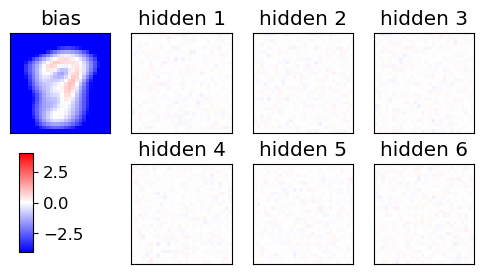

Starting the training, POTTS=True
[ 8537 17772 17305 18047  7742 19161   154  2629 13351 12466 12476 14721
  1963  6227 20175 14243  2807  7296 11400  9931   888 14468 15749 15006
  3381  9108 17985 12133 18029  5330 14089  1282   971 17087 19256 10225
  8643 13861 18127  1187]
[15155  6749 20350 15109 15302 13927  2382  7326 13895 15164  9332 17893
  2474 18589  3082 12039 15885  5309 13523 10912 14592 17814  7066 15542
   920 10638 13965  3076 14286   155 20745  1744 15363  7848 20506  6244
 13866 20338  3152   820]
[ 4003 14553 11180  8249 10277   508 13465 20721 14772 11566 18463 20862
  4303  1494  4540  7393 16639  1868 10757 19484 17573  3082 11279 15478
 12481 19904  2140 20315 18745  1427 14531 12873 17456 17364 14375  8020
 12365 13693  5712  1350]
[  772 10995  9789 18433  4638  5723  1318 10140  2161 19909 19266  3379
  1784 19547 13525  3044  1403 13691  4029  7260  3485  4559  6104  3937
 20573 17095 20804  6852 12454  2483  6007  2008  1235 11671  9044   131
  6348  8600

In [ ]:
np.random.seed(12345)

print(f"Nepoch={Nepoch}\nNmini={Nmini}")
# recording history of weights ("E" means epoch)
wE,aE,bE=np.zeros((Nepoch+1,D,L)),np.zeros((Nepoch+1,D)),np.zeros((Nepoch+1,L)) 
wE[0],aE[0],bE[0]=np.copy(w),np.copy(a),np.copy(b)
gwE,gw2E,gwE_d,gwE_m = np.zeros_like(wE),np.zeros_like(wE),np.zeros_like(wE),np.zeros_like(wE)
gaE,ga2E,gaE_d,gaE_m = np.zeros_like(aE),np.zeros_like(aE),np.zeros_like(aE),np.zeros_like(aE)
gbE,gb2E,gbE_d,gbE_m = np.zeros_like(bE),np.zeros_like(bE),np.zeros_like(bE),np.zeros_like(bE)
miniE = np.zeros(Nepoch+1)
pzE=np.zeros((Nepoch+1,Nz))

if GRAD=="RMSprop": 
    gw2,ga2,gb2 = np.zeros_like(w),np.zeros_like(a),np.zeros_like(b)

indices=np.arange(Nd).astype("int")
plot_weights_bias(wE, aE, 0, L, cols=L//2, save=False)

# for the plot with panels
Ncols=min(8,max(2,L//2))

if POTTS: print("Starting the training, POTTS=True")
else: print("Starting the training")
#for L in np.arange(4,9,1):

configurations = generate_configurations(L)
log_likelihoods = []
lista_epoch_grafico = []
# Note: here an epoch does not analyze the whole dataset
for epoch in range(1,1+Nepoch):
    # q maps epochs to interval [0,1]
    q = (epoch-1.)/(Nepoch-1.) 
    # N, size of the mini batch
    # stays closer to N_ini for some time, then it progressively accelerates toward N_fin
    N = int(N_ini + (N_fin-N_ini)*(q**2))
    #  l_rate interpolates between initial and final value
    l_rate = l_rate_ini + (l_rate_fin-l_rate_ini)*q

    for mini in range(Nmini):
        # initializitation for averages in minibatch
        # visible variables "v" --> "x"
        #  hidden variables "h" --> "z"
        x_data, x_model = np.zeros(D),np.zeros(D)
        z_data, z_model = np.zeros(L),np.zeros(L)
        xz_data,xz_model= np.zeros((D,L)),np.zeros((D,L))
        pz = np.zeros(L)

        # Minibatch of size N: points randomply picked (without repetition) from data
        selected = np.random.choice(indices,N,replace=False)
        if epoch==1 and mini<=3: print(selected)

        for k in range(N):
            ###################################
            x0 = data[selected[k]]
            # positive CD phase: generating z from x[k]
            z = CD_step(x0,w,b,POTTS=POTTS)
            x_data  += x0
            z_data  += z
            xz_data += np.outer(x0,z)
            # fantasy
            zf=np.copy(z)
            # Contrastive divergence with Nt steps
            for t in range(Nt):
                # negative CD pzase: generating fantasy xf from fantasy zf
                xf = CD_step(zf,w.T,a)
                # positive CD phase: generating fantasy zf from fantasy xf 
                zf = CD_step(xf,w,b,POTTS=POTTS)
            x_model += xf
            z_model += zf
            xz_model+= np.outer(xf,zf)
            # recording probability of encoding in z-space, if POTTS
            if POTTS: pz[zf]+=1
            ###################################

        # gradient of the likelihood: follow it along its positive direction
        gw_d,gw_m = xz_data/N, xz_model/N
        ga_d,ga_m = x_data/N, x_model/N
        gb_d,gb_m = z_data/N, z_model/N
        gw=np.copy(gw_d - gw_m)
        ga=np.copy(ga_d - ga_m)
        gb=np.copy(gb_d - gb_m)

        # gradient ascent step
        if GRAD=="RMSprop":
            # RMSprop gradient ascent
            gw2 = beta*gw2+(1-beta)*np.square(gw)
            ga2 = beta*ga2+(1-beta)*np.square(ga)
            gb2 = beta*gb2+(1-beta)*np.square(gb)
            w += l_rate*gw/sqrt(epsilon+gw2)
            a += l_rate*ga/sqrt(epsilon+ga2)
            b += l_rate*gb/sqrt(epsilon+gb2)
        else: 
            # defaulting to the vanilla stochastic gradient ascent (SGD)
            w += l_rate*gw
            a += l_rate*ga
            b += l_rate*gb
        # regularization (LASSO)
        if gamma>0.:
            w -= (gamma*l_rate)*sign(w)
            a -= (gamma*l_rate)*sign(a)
            b -= (gamma*l_rate)*sign(b)

    wE[epoch],gwE[epoch],gwE_d[epoch],gwE_m[epoch]=np.copy(w),np.copy(gw),np.copy(gw_d),np.copy(gw_m)
    aE[epoch],gaE[epoch],gaE_d[epoch],gaE_m[epoch]=np.copy(a),np.copy(ga),np.copy(ga_d),np.copy(ga_m)
    bE[epoch],gbE[epoch],gbE_d[epoch],gbE_m[epoch]=np.copy(b),np.copy(gb),np.copy(gb_d),np.copy(gb_m)
    miniE[epoch]=N
    if POTTS: pzE[epoch] = pz/np.sum(pz)
    print("epoch",epoch,"/",Nepoch," Nt:",Nt," N:",N," L:",L,
          " rate:",l_rate," gam:",gamma,"SPINS=",SPINS,"POTTS=",POTTS)

    if Nepoch<=100 or epoch%20==0 or epoch==Nepoch:
        plot_weights_bias(wE, aE, epoch, L, cols=Ncols, save=False)

    if epoch%5==0:
        partition = partition_function(configurations)
        log_likelihood = compute_log_likelihood(partition,data, a=a, b=b, w=w,)
        log_likelihoods.append(log_likelihood)
        lista_epoch_grafico.append(epoch)
        print(f'Epoch {epoch + 1}, Log-Likelihood: {log_likelihood}')
    str_time_completion = datetime.datetime.now().strftime("_%Y%m%d_%H%M")

fig, ax = plt.subplots(1,2, figsize=(10,6))
plt.sca(ax[0])
plt.plot(lista_epoch_grafico, log_likelihoods, '-')
plt.title(f'LLH in {Nepoch} epochs, L={L}, CD steps={Nt}')
plt.xlabel('Epochs')
plt.ylabel('LLH')
plt.sca(ax[1])
plt.text(0.1,0.5, stringa)
plt.axis('off')


plt.savefig(f'img/Random_search_LLH_epoch{Nepoch}_L{L}_CD{Nt}.png')
plt.show()
print("END of learning phase")

## Test generative power of the trained RBM

<Figure size 640x480 with 0 Axes>

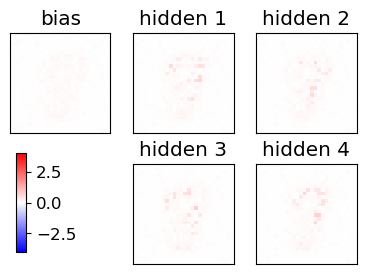

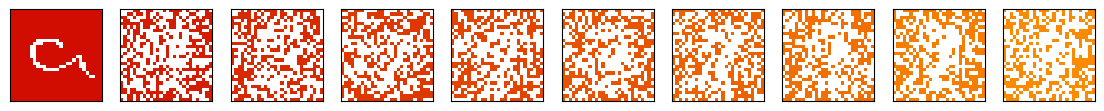

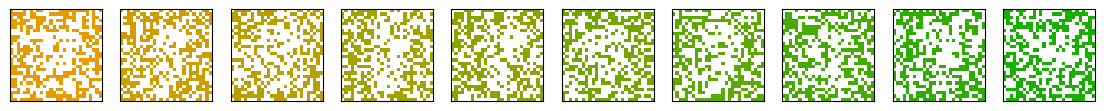

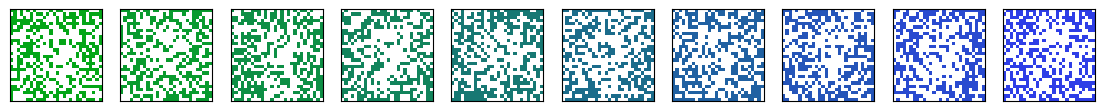

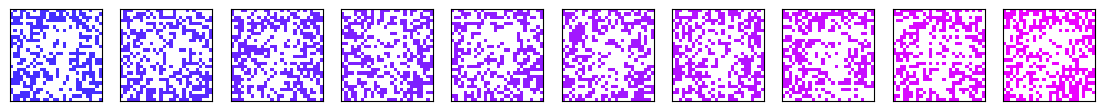

L: 4     amplification of weights: 1.0


In [41]:
ee=-1 ##
NN=200
traj_x,traj_z = np.zeros((NN+2,D)), np.zeros((NN+2,L))
xf=np.copy(data[np.random.randint(Nd)])
traj_x[0]=np.copy(xf)

# AF: multiply weights and biases by a number >1 to achieve a more deterministic behavior,
# equivalent to lower the temperature in a Boltzmann weight -> select lowest energies
# Note: here, this is done in the negative CD step only
AF=1.

for t in range(NN):
    t1=t+1
    # positive CD phase: generating fantasy zf from fantasy xf
    zf = CD_step(xf,1*wE[ee],1*bE[ee],POTTS=POTTS)
    traj_z[t] = np.copy(zf)
    # negative CD pzase: generating fantasy xf from fantasy zf
    xf = CD_step(zf,AF*wE[ee].T,AF*aE[ee])
    traj_x[t1] = np.copy(xf)


plot_weights_bias(wE, aE, Nepoch, L, cols=Ncols, save=True)

col0,col1,col2,col3,col4=(0.8,0,0,1),(1,0.6,0,1),(0,.7,0,1),(0.2,0.2,1,1),(1,0,1,1)
show_MNIST(traj_x[0:],Nex=10,colors=(col0,col1))
show_MNIST(traj_x[10:],Nex=10,colors=(col1,col2))
show_MNIST(traj_x[20:],Nex=10,colors=(col2,col3))
show_MNIST(traj_x[40:],Nex=10,colors=(col3,col4))
print("L:",L,"    amplification of weights:",AF)

## Plot of the gradient amplitude

NE= 150


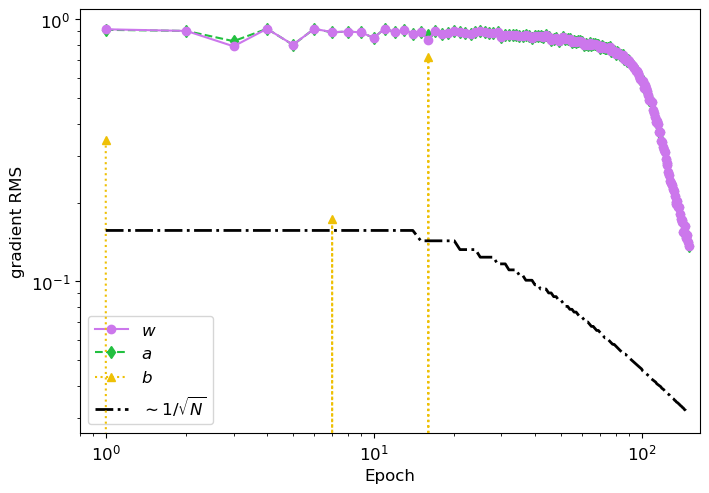

FIG/RBM_grad_MNIST3_E150_N5-125_SGD-1.0-0.25_CD-4_L4_reg0.001.png


In [42]:
def make_fname(strin):
    fname="FIG/RBM_"+strin+"_MNIST"+str(Ndigit)+"_E"+str(NE)+"_N"+str(N_ini)+"-"+str(N_fin)
    fname=fname+"_"+GRAD+"-"+str(l_rate_ini)+"-"+str(l_rate_fin)+"_CD-"+str(Nt)+"_L"+str(L)
    if gamma>0:  fname=fname+"_reg"+str(gamma)
    return fname+".png"

NE = len(gwE)-1
print("NE=",NE)
mgw,mga,mgb,epo=np.zeros(NE),np.zeros(NE),np.zeros(NE),np.zeros(NE)
DE=1
if NE>30: DE=2
if NE>50: DE=5
if NE>100: DE=10
# compute RMS average of gradients during epochs
for ep in range(1,1+NE):
    epo[ep-1]=ep
    mgw[ep-1] = np.std(gwE[ep])
    mga[ep-1] = np.std(gaE[ep])
    mgb[ep-1] = np.std(gbE[ep])

#############################################################################
# creating grid for subplots
fig, ax = plt.subplots(1, 1, figsize=(8,5.5))
fig.subplots_adjust( left=None, bottom=None,  right=None, top=None, wspace=None, hspace=None)
        
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(DE))
ax.plot(epo,mgw,"o-",c="#CC77EC",label="$w$",zorder=10)
ax.plot(epo,mga,"d--",c="#22C040",label="$a$",zorder=5)
ax.plot(epo,mgb,"^:",c="#EEC006",label="$b$",zorder=8)
ax.plot(epo,.35/sqrt(miniE[1:]),"k-.",label="$\\sim 1 / \\sqrt{N}$",zorder=20,lw=2)
ax.set_xlabel("Epoch")
ax.set_ylabel("gradient RMS")
ax.set_xlim(0.5,NE+0.5)
if 1==2: ax.set_ylim(0,)
else: 
    ax.set_xlim(0.8,Nepoch*1.1)
    ax.set_xscale("log")
    ax.set_yscale("log")
ax.legend()

fname=make_fname("grad")
fig.savefig(fname,dpi=200,bbox_inches='tight',pad_inches=0.02, transparent=False)
plt.show()
print(fname)

## Save weights over epochs on file

In [43]:
def make_weights_fname(label,dname="WEIGHTS"):
    fname=dname+"/"+label+"_"+str_simul+"_MNIST"+str(Ndigit)+"_L"+str(L)
    fname=fname+"_"+GRAD+"-"+"{:.2f}".format(l_rate_ini)+"-"+"{:.2f}".format(l_rate_fin)+"_Ep"+str(Nepoch)
    if gamma>0:  fname=fname+"_reg"+"{:.3g}".format(gamma)
    if POTTS: fname+="_POTTS"
    if SPINS: fname+="_SPINS"
    fname=fname+str_time_completion
    return fname+".npy"

def save_epochs(qE,label):
    fname=make_weights_fname(label)
    print(fname)
    np.save(fname,qE)

save_epochs(wE,"w")
save_epochs(bE,"b")
save_epochs(aE,"a")

WEIGHTS/w_RBM_MNIST3_L4_SGD-1.00-0.25_Ep150_reg0.001_SPINS_20250320_1121.npy
WEIGHTS/b_RBM_MNIST3_L4_SGD-1.00-0.25_Ep150_reg0.001_SPINS_20250320_1121.npy
WEIGHTS/a_RBM_MNIST3_L4_SGD-1.00-0.25_Ep150_reg0.001_SPINS_20250320_1121.npy


# RESULTS

#### 1. Initialization of biases

Explain the initialization of visible biases proposed by Hinton.

In [23]:
import os
from IPython.display import display
from PIL import Image
import matplotlib.pyplot as plt

# Path to your images
folder_path = "img/"
files = [(f, os.path.getmtime(os.path.join(folder_path, f))) for f in os.listdir(folder_path)] #add thing that selects just .png
# Sort files by modification time (oldest first)
files_sorted = sorted(files, key=lambda x: x[1])

# Extract sorted file names
sorted_filenames = [f[0] for f in files_sorted]
sorted_filenames = sorted_filenames[:-2]


row,cols = 5,6
fig,axes = plt.subplots(row,cols, figsize=(15,10))
axes = axes.flatten()
for i, img in enumerate(sorted_filenames[:row*cols]):
    image = Image.open('img/' +img)
    axes[i].imshow(image)
    axes[i].axis('off')
plt.tight_layout()
plt.show()

IsADirectoryError: [Errno 21] Is a directory: '/home/gigi/LCP-B/ex2/img/digit012'

#### 2. Log-likelihood

Take an RBM with L=3 hidden units and compute the log-likelihood L of data during training (see the notes). Does it grow during training? Does it depend on the number of contrastive divergence steps?  Then compare the log-likelihood L at the end of training for L=3, 4, 5, 6, … up to a maximum L of your choice.

We trained the RBM on digits 7,8,9, trying with number of hidden units L $\in [3,4,5,6,7]$, and for each value we tried different CD steps, $Nt \in [2,4,6,8,10,12]$.

Log-likelihood generally increases during training, what you can see in the resume above are graphs of the LL taken every 5 epochs to spare us computational time and get as soon as possible an overview.

What we see is that number of CD steps matters a little bit in LL increase, 2-3 points, and it depends more on the number of hidden units. Best final values are for L=7. It is interesting to see that sometimes LL stalls after a initial steep increase. We hope to find an explanation during phase of hyperparameter tuning.




cross validation: fixed hyperparameters, and multiple runs w/ different random seeds. and then mean and std of final LLH